<br>Last Verified to Run: **2022-05-11**

<br>Software Versions:
  - `ts_wep`: **v2.3.0**
  - `lsst_distrib`: **w_2022_19**
  
## Goal
Take raw auxTel images, run ISR, and pass through the AOS pipeline to recover Zernikes. We explore two options: viability of using the WCS information attached to the in-focus exposure to arrive at donut catalog, and using donut template fitting with the defocal exposure to arrive at donut catalog.  


## Setup
    
   * access to NCSA lsst-devl nodes 
   * working installation of ts_wep package ( see the following [notes](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) for additional info on how to install and build the AOS packages)
    
It is assumed that `ts_analysis_notebooks` resides in `$PATH_TO_TS_ANALYSIS_NOTEBOOKS`,  `$USER` is the username,
and `ts_wep` is installed in `$PATH_TO_TS_WEP`.

At least once after cloning the `ts_analysis_notebooks` repo one needs to run the `setup` and `scons` commands. It can be  for example:
   
    cd $PATH_TO_TS_ANALYSIS_NOTEBOOKS
    setup -k -r .
    scons 

### Option A : using LSP 

After authenticating VPN, and opening a new machine on https://lsst-lsp-stable.ncsa.illinois.edu/ one can run this notebook on LSP, assuming that the setup sourcing the location of `ts_wep` and `ts_analysis_notebooks` has been added to  `${HOME}/notebooks/.user_setups` , for instance


    setup ts_wep -t $USER  -k -r /project/scichris/aos/ts_wep/
    setup ts_analysis_notebooks -k -r $PATH_TO_TS_ANALYSIS_NOTEBOOKS
     
### Option B: tunneling jupyter notebook to a browser via SSH

Setup (that was used to run a notebook opened in a browser using an ssh connection to the NCSA machine). The `54467` can be any other port number, as long as it is consistent between `ssh` connection and the jupyter notebook.
    
Run in the terminal on the local machine:

    ssh -L 54467:localhost:54467 $USER@lsst-devl02
    
Run in the NCSA terminal after DUO authentication:

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib 
    
    setup ts_wep -t $USER  -k -r $PATH_TO_TS_WEP
    setup ts_analysis_notebooks -k -r $PATH_TO_TS_ANALYSIS_NOTEBOOKS
    
    jupyter notebook --no-browser --port=54467 
   
This should open the browser at the NCSA `/jhome` directory.  I navigate to `$PATH_TO_TS_ANALYSIS_NOTEBOOKS` to open this notebook.





## Imports

In [1]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import astropy.units as u

import matplotlib.pyplot as plt
import numpy as np 
from lsst.daf import butler as dafButler
from lsst.daf.persistence import Butler
import lsst.geom
import lsst.utils.tests
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.afw.image import FilterLabel
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay

from matplotlib import rcParams 

from copy import copy
from copy import deepcopy
import yaml

from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig
)
from lsst.ts.wep.task.EstimateZernikesLatissTask import (
    EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
)

from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface

from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (
    GenerateDonutCatalogWcsTask, GenerateDonutCatalogWcsTaskConfig)

from lsst.ts.analysis.notebooks import plotting_tools as pt


In [2]:
rcParams['ytick.labelsize'] = 13
rcParams['xtick.labelsize'] = 13
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 15

## 1) Example workflow using updated WCS information 

## 1.1) Load the raws and ensure that there are intra, extra, and in-focus images 

/lsstdata/offline/instrument/LATISS/storage/2021-09-08/AT_O_20210908_000487-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-09-08/AT_O_20210908_000488-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-09-08/AT_O_20210908_000489-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


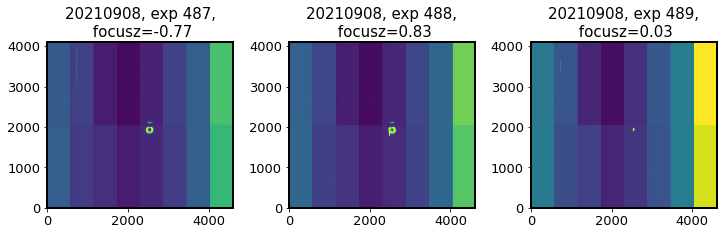

In [3]:
%matplotlib inline
# analyze that for the test data 
pt.preview_exposures(year_month_day='20210908', exp_start=487, exp_end=490,
                    dataset_ref_or_type='raw',
                    collection="LATISS/raw/all")


## 1.2) Run the ISR 

First try with flats:


    ssh lsst-devl02

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib
    
    pipetask run  --data-query "exposure IN (2021090800487..2021090800489) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISRex --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types

The config file `testLatiss4.yaml` contains 

    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.Latiss
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: false
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doNanMasking: false
          doOverscan: true
          doVariance: false
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'

While running the pipetask (with `lsst_distrib` version `w_2022_05`) I get the following warning :

    ...
    numexpr.utils INFO: Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
    numexpr.utils INFO: NumExpr defaulting to 8 threads.
    lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 7 quanta for 1 tasks, graph ID: '1643835917.696073-3368255'
    conda.common.io INFO: overtaking stderr and stdout
    conda.common.io INFO: stderr and stdout yielding back
    py.warnings WARNING: /software/lsstsw/stack_20220125/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/obs_base/g20ff5da1ef+c94f9176fe/python/lsst/obs/base/formatters/fitsExposure.py:651: UserWarning: Reading file:///repo/main/u/czw/DM-32209/flatGen.20211013a-felh/20211013T214128Z/flat/r/FELH0600~empty/flat_LATISS_r_FELH0600~empty_RXX_S00_u_czw_DM-32209_flatGen_20211013a-felh_20211013T214128Z.fits with data ID {instrument: 'LATISS', detector: 0, physical_filter: 'FELH0600~empty', ...}: filter label mismatch (file is None, data ID is FilterLabel(band="r", physical="FELH0600~empty")).  This is probably a bug in the code that produced it.
      warnings.warn(
      ...

But it executes successfully. Show the postISR:


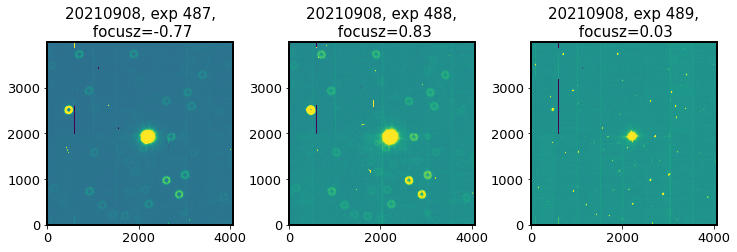

In [4]:
%matplotlib inline
pt.preview_exposures(year_month_day='20210908', exp_start=487, exp_end=490,
                    dataset_ref_or_type='postISRCCD',
                    collection='u/scichris/Latiss/postISRex')

## 1.3) Find how far off is the WCS using the in-focus exposure 

Now the expected problem for some auxTel images was that the WCS attached to the exposure is 180 degree + several pixels off. Illustrate that by plotting the GAIA source catalog given the original WCS as well as rotated WCS:

In [5]:
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800489
                                        },
                      collections=['u/scichris/Latiss/postISRex'])


I load the sources from the reference catalog using the `ts_wep`  `GenerateDonutCatalogWcsTask` : 

In [6]:
# need to provide ra,dec, rotation angle of the exposure 
visitInfo = postIsr.getInfo().getVisitInfo()

boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()

# Load the ts_wep RefCatalogInterface
refCatInterface = RefCatalogInterface(boresightRa, boresightDec,boresightRotAng)

htmIds = refCatInterface.getHtmIds()


butler = dafButler.Butler('/repo/main/', instrument='LATISS')
catalogName = 'gaia_dr2_20200414'
collections = 'refcats'

dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)


donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
donutCatConfig.filterName= 'phot_g_mean'
donutCatConfig.donutSelector.fluxField = 'phot_g_mean_flux'


In [7]:
# instantiate the task with the appropriate config 
donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }


Illustrate the original WCS and the 180-deg off WCS to check whether the 180 degree offset has been resolved (the ticket is marked as  'Done' https://jira.lsstcorp.org/browse/DM-31997)

In [8]:
# Get sources from reference catalog assuming the original WCS
originalWcs = postIsr.getWcs()
originalDonutCatStruct = donutCatTask.run(dataRefs, postIsr, )

In [9]:
# Obtain sources from the reference catalog with the WCS rotated by 180 degrees 
rotationInDeg = 180 

info = postIsr.getInfo().getVisitInfo()
orientation = (info.getBoresightRotAngle().asDegrees()+rotationInDeg)* lsst.geom.degrees
#  info.getBoresightRotAngle()# 0 * lsst.geom.degrees  # 
flipX = originalWcs.isFlipped
scale =  originalWcs.getPixelScale() # 0.2 * lsst.geom.arcseconds  # how many arcsec per pixel 
cdMatrix = makeCdMatrix(scale=scale, orientation=orientation, flipX=flipX)

pxOrigin = originalWcs.getPixelOrigin()

crpix = pxOrigin
crval = originalWcs.getSkyOrigin() # lsst.geom.SpherePoint(0.0*lsst.geom.degrees, 0.0*lsst.geom.degrees)
rotatedWcs = makeSkyWcs(crpix=crpix, crval=crval, cdMatrix=cdMatrix)

Compare the original and rotated WCS:

In [10]:
originalWcs

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [11]:
rotatedWcs

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [12]:
# obtain source catalog using the rotated WCs postIsr.setWcs(rotatedWcs)
postIsr.setWcs(rotatedWcs)
rotatedDonutCatStruct =  donutCatTask.run(dataRefs, postIsr, )

In [13]:
# Make magnitude cuts for cleaner illustration
originalCatalog  = originalDonutCatStruct.donutCatalog
rotatedCatalog = rotatedDonutCatStruct.donutCatalog

mag_list = (originalCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

originalCatalog['mags'] = mag_array
mask = mag_array<16
originalCatalogMagCut = originalCatalog[mask]


mag_list = (rotatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

rotatedCatalog['mags'] = mag_array
mask = mag_array<16
rotatedCatalogMagCut = rotatedCatalog[mask]


Plot the postISR image with GAIA sources given the original WCS (yellow) and WCS rotated by 180 degrees (red):

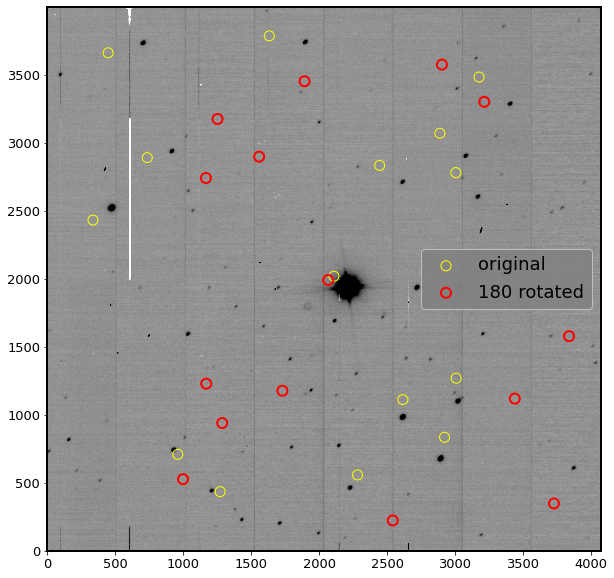

In [14]:
%matplotlib inline

zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
for cat,color,lw,label in zip([originalCatalogMagCut, rotatedCatalogMagCut], 
                    ['yellow', 'red'],
                       [1,2],
                       ['original', '180 rotated']):

    ax.scatter(cat['centroid_x'], 
           cat['centroid_y'], 
           s=100, 
           facecolors='none', edgecolors=color, lw=lw, 
           label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

We see that the original WCS attached to auxTel exposure is several tens of pixels + some rotation off,  but it's not 180 degrees off. So at least for this dataset, this is not an issue any more. 

## 1.4) Attempt to run astrometry using original WCS as a first guess 

Either way,  the original WCS is still ~20px off. 

We first try using it as a first guess for the astrometry task:

In [15]:
%matplotlib inline
astromConfig = AstrometryTask.ConfigClass()
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.999
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 2
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15

Need to redefine filter label

In [16]:
# I'm forcing the exposure
# to have the same name as the one in the Gaia catalog for now

postIsr.setFilterLabel(FilterLabel('phot_g_mean'))

Need to turn the `struct` to `sourceCatalog` - feeding `originalDonutCatStruct` to `solver.run` would not work, because it's not of `sourceCatalog` type. We turn `struct` into `sourceCatalog` by iterating over all rows, populating a new `afwTable.SourceCatalog` with sources... Based on [this notebook](https://github.com/lsst-ts/ts_phosim/blob/uw_dev/notebooks/analysis_notebooks/Create_wcs_from_phosim_out_of_focus_no_transpose.ipynb) :

In [17]:
sourceSchema = afwTable.SourceTable.makeMinimalSchema()
measBase.SingleFrameMeasurementTask(schema=sourceSchema)  # expand the schema
sourceCat = afwTable.SourceCatalog(sourceSchema)

sourceCentroidKey = afwTable.Point2DKey(sourceSchema["slot_Centroid"])
sourceIdKey = sourceSchema["id"].asKey()
sourceRAKey = sourceSchema["coord_ra"].asKey()
sourceDecKey = sourceSchema["coord_dec"].asKey()
sourceInstFluxKey = sourceSchema["slot_ApFlux_instFlux"].asKey()
sourceInstFluxErrKey = sourceSchema["slot_ApFlux_instFluxErr"].asKey()

catalog = originalCatalogMagCut

Nrows = len(catalog)
sourceCat.reserve(Nrows)

for i in range(Nrows):
    src = sourceCat.addNew()
    src.set(sourceIdKey, i)
    
    # set ra,dec 
    ra = lsst.geom.Angle(catalog['coord_ra'].iloc[i], lsst.geom.radians)
    src.set(sourceRAKey, ra)

    dec = lsst.geom.Angle(catalog['coord_dec'].iloc[i], lsst.geom.radians)
    src.set(sourceDecKey, dec)

    # set the x,y centroid
    x = catalog['centroid_x'].iloc[i]
    y = catalog['centroid_y'].iloc[i]
    point = lsst.geom.Point2D(x,y)
    src.set(sourceCentroidKey, point)

    # set the flux and assume some small 1% flux error
    flux =  catalog['source_flux'].iloc[i]
    src.set(sourceInstFluxKey, flux)
    
    fluxErr = flux / 100.
    src.set(sourceInstFluxErrKey, fluxErr)

Display the WCS before and after to illustrate that running the `AstrometryTask` solver does update the WCS attached to the exposure

In [18]:
postIsr.getWcs()

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [ ]:
solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=sourceSchema,)
results = solver.run(sourceCat=sourceCat, exposure=postIsr,)

This didn't work - the initial source location is too far for astrometry to converge:

    File /software/lsstsw/stack_20220421/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_astrom/g9dfd734f39+94a739ecb7/python/lsst/meas/astrom/astrometry.py:301, in AstrometryTask.solve(self, exposure, sourceCat)
    295 self.log.info(
    296     "Matched and fit WCS in %d iterations; "
    297     "found %d matches with on-sky distance mean and scatter = %0.3f +- %0.3f arcsec",
    298     iterNum, len(tryRes.matches), tryMatchDist.distMean.asArcseconds(),
    299     tryMatchDist.distStdDev.asArcseconds())
    300 if tryMatchDist.distMean.asArcseconds() > self.config.maxMeanDistanceArcsec:
--> 301     raise pipeBase.TaskError(
    302         "Fatal astrometry failure detected: mean on-sky distance = %0.3f arcsec > %0.3f "
    303         "(maxMeanDistanceArcsec)" %
    304         (tryMatchDist.distMean.asArcseconds(), self.config.maxMeanDistanceArcsec))
    305 for m in res.matches:
    306     if self.usedKey:

    TaskError: Fatal astrometry failure detected: mean on-sky distance = 7.155 arcsec > 0.500 (maxMeanDistanceArcsec)

Earlier when I tried doing "rotate+shift WCS until the reference source catalog matches the observed sources" on the same exposure I needed rotation of ~6 degrees and several tens of px offset. For astrometry the max rotation is < 6 deg. 

## 1.5) Run astrometry task using corrected WCS via source detection task 

Here I convolve the image with Gaussian PSF to detect sources, and use that as an input for astrometry task. This approach could be turned to `ts_wep` task if needed, but it would require three exposures (one in-focus to detect sources, and two defocal, at the ~exact same position).

In [19]:
# Read the exposure again
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800489
                                        },
                      collections=['u/scichris/Latiss/postISRex'])

In [20]:
def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

Illustrate the kernel:

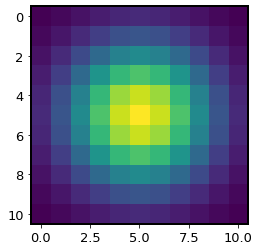

In [22]:
psf_array = gkern(l=11, sig=2.5)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)
plt.imshow(psf_image.array)

postIsr.setPsf(psf)

Run the `SourceDetectionTask`:

In [23]:
schema = lsst.afw.table.SourceTable.makeMinimalSchema()

configDetection = SourceDetectionTask.ConfigClass()
configDetection.thresholdValue = 30  # detection threshold in units of thresholdType
configDetection.thresholdType = "stdev"  # units for thresholdValue
configDetection.includeThresholdMultiplier = 1.0 
configDetection.minPixels = 500
#configDetection.charImage.background.weighting = False  
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=configDetection)


measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table

# create copy of image to explicitly set the PSF
exposure = deepcopy(postIsr)
exposure.setPsf(psf)

# Run the detect the measure tasks
detect_result = detect.run(table, exposure,)

catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
measure.run(catalog, exposure)

/software/lsstsw/stack_20220421/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gcdb44b6e2f+f8ddabfbee/python/lsst/meas/algorithms/detection.py:413: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20220421/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gcdb44b6e2f+f8ddabfbee/python/lsst/meas/algorithms/detection.py:450: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


Plot the resulting source catalog:

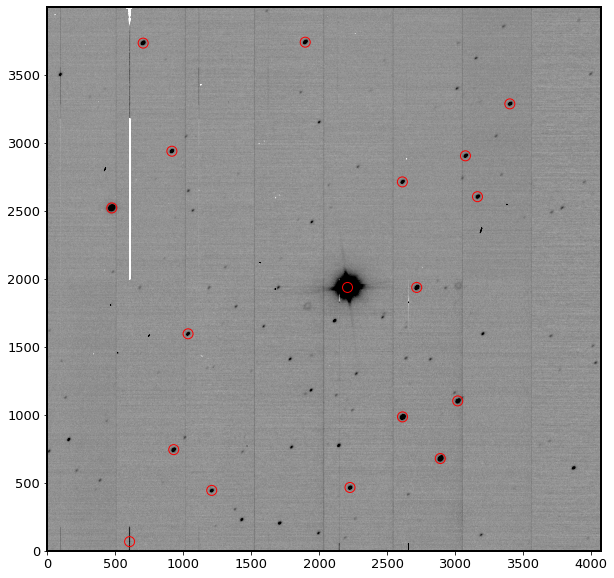

In [24]:
%matplotlib inline
zscale = ZScaleInterval()
data = postIsr.getImage().getArray()
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
ax.scatter(catalog['slot_Centroid_x'], catalog['slot_Centroid_y'],s=100,facecolors='none', edgecolors='red',)

We see that this nicely detected sources (setting threshold to $30 \sigma$ ignored fainter stars which is fine, since we don't need all of them for astrometry).

Use that source catalog as an input for `AstrometryTask` fit:

In [25]:
# As above, I'm forcing the exposure
# to have the same name as the one in the Gaia catalog for now
postIsr.setFilterLabel(FilterLabel('phot_g_mean'))

In [26]:
# need to provide ra,dec, rotation angle of the exposure 
visitInfo = postIsr.getInfo().getVisitInfo()

boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()

# Load the ts_wep RefCatalogInterface
refCatInterface = RefCatalogInterface(boresightRa, boresightDec,boresightRotAng)

htmIds = refCatInterface.getHtmIds()


butler = dafButler.Butler('/repo/main/', instrument='LATISS')
catalogName = 'gaia_dr2_20200414'
collections = 'refcats'

dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)


donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
donutCatConfig.filterName= 'phot_g_mean'
donutCatConfig.donutSelector.fluxField = 'phot_g_mean_flux'

# instantiate the task with the appropriate config 
donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }


In [27]:
# store the unchanged WCS in a variable to compare to the changes done 
# by running astrometry fit 
originalWcs = postIsr.getWcs()

In [28]:
astromConfig = AstrometryTask.ConfigClass()
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.999
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 2
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15

schema = lsst.afw.table.SourceTable.makeMinimalSchema()
solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
results = solver.run(sourceCat=catalog, exposure=postIsr,)

Running the astrometry task updates the WCS attached to the postIsr exposure. Compare the original and updated WCS:

In [29]:
originalWcs

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [30]:
postIsr.getWcs()

FITS standard SkyWcs:
Sky Origin: (306.9575674280, -87.4684455328)
Pixel Origin: (1930.01, 1989.89)
Pixel Scale: 0.0957529 arcsec/pixel

We see that they are different! Pull sources based on that WCS from the reference catalog, to make sure that it is the correct WCS:

In [31]:
updatedDonutCat =  donutCatTask.run(dataRefs, postIsr, )

updatedCatalog  = updatedDonutCat.donutCatalog

mag_list = (updatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

updatedCatalog['mags'] = mag_array
mask = mag_array<16
updatedCatalogMagCut = updatedCatalog[mask]


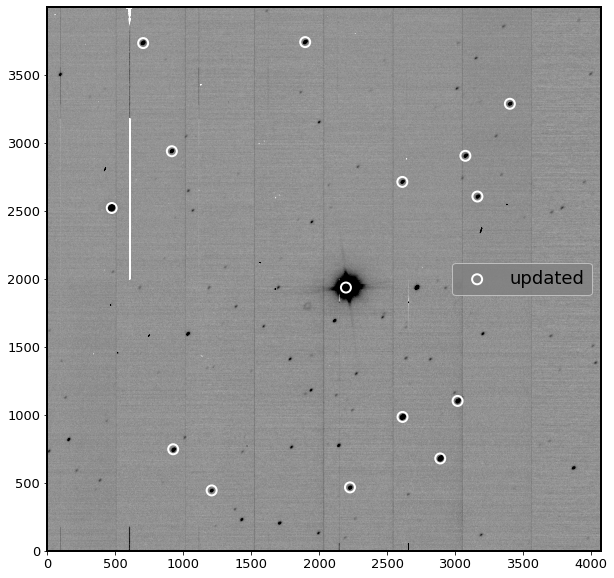

In [32]:
%matplotlib inline

zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
cat = updatedCatalogMagCut
color = 'white'
lw=2
label='updated'

ax.scatter(cat['centroid_x'], 
       cat['centroid_y'], 
       s=100, 
       facecolors='none', 
        edgecolors=color, lw=lw, 
       label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')


This was just to confirm that the WCS that the astrometry arrived at is indeed correct! So these sources can be used as an input donut location to run the AOS pipeline.

## 1.6 ) WCS update as a function

The WCS update method using the in-focus exposure can be put together as a function that returns an updated WCS and source catalog that can be used for Zernike fitting.

In [33]:
# define the kernel
def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

def get_updated_wcs(path_to_repo='/repo/main/', 
                   instrument='LATISS',
                   collection='u/scichris/Latiss/postISRex',
                   detector=0,
                   exp_num=2021090800489,
                   gkernel_length=11,
                   gkernel_sig=2.5,
                   sd_threshold_type="stdev",
                   sd_threshold_value= 30,
                   sd_min_pixels=500,
                   refcat_collection='refcats',
                   refcat_catalog_name = 'gaia_dr2_20200414',
                   refcat_filter_label='phot_g_mean',
                   astrom_mag_min = 10,
                   astrom_mag_max = 16,
                   ):
    '''
    A function to take the in-focus exposure, fit sources
    with sourceDetection task, and return updated WCS as
    well as resulting source (donut) catalog.
    
    Parameters
    ----------
    path_to_repo : str (optional)
        Path to butler repository containing the collection
        with postISR exposures, as well as 'refcats'
    collection: str (optional)
        Collection name containing the postISR in-focus exposure

        We assume just one collection containing all data.
        For Latiss tests a collection name
        can be "u/scichris/Latiss/test"

        For ts_phosim runs collections are usually
        f'ts_phosim_90060{iterN}1', where "iterN" is iteration
        number.
    instrument: str (optional)
        Name of instrument eg. LsstCam, LsstComCam, or LATISS
    detector: str or int (optional)
        Name of detector. For LATISS it is 0 , for
        LsstComCam eg. "R22_S10"
    exp_num: int (optional)
        Exposure number, eg. 2021090800489
    gkernel_length: int (optional)
        Length of the Gaussian kernel used to create fiducial PSF
    gkernel_sig: float (optional)
        Sigma (width) of the Gaussian PSF kernel
    sd_threshold_type: str (optional)
        Source detection threshold type.
    sd_threshold_value: float (optional)
        Source detection threshold value in units of threshold type.
    sd_min_pixels: float (optional)
        Source detection minimum pixel count.
    refcat_collection: str (optional)
        Reference collection name.
    refcat_catalog_name: str (optional)
        Reference catalog name.
    refcat_filter_label: str (optional)
        Filter label for the reference catalog.
    astrom_mag_min: float (optional)
        Minimum magnitude for astrometry task matching.
    astrom_mag_max: float (optional)
        Maximum magnitude for sources considered for astrometry task, 
        and the returned source (donut) catalog.
    
    Returns
    -------
    updated_wcs: lsst.afw.geom.SkyWcs 
        WCS from the in-focus exposure, updated after running 
        sourceDetection task 
    updatedCatalogMagCut : pandas.core.frame.DataFrame
        Updated donut catalog, cut at a chosen magnitude
    
    '''
    
    # read the exposure
    butler = dafButler.Butler(path_to_repo, instrument=instrument)
    postIsr = butler.get('postISRCCD', dataId={'instrument':instrument, 
                                               'detector':detector, 
                                               'exposure':exp_num
                                            },
                          collections=[collection])

    # set Gaussian kernel
    psf_array = gkern(l=gkernel_length, sig=gkernel_sig)
    psf_array = psf_array.astype(np.float64)
    psf_image = lsst.afw.image.ImageD(psf_array)
    psf_kernel = lsst.afw.math.FixedKernel(psf_image)
    psf = lsst.meas.algorithms.KernelPsf(psf_kernel)
    postIsr.setPsf(psf)

    # Run the SourceDetectionTask,
    # measure sources using simple PSF (no deblending)
    schema = lsst.afw.table.SourceTable.makeMinimalSchema()

    configDetection = SourceDetectionTask.ConfigClass()
    configDetection.thresholdValue = sd_threshold_value
    configDetection.thresholdType = sd_threshold_type
    configDetection.includeThresholdMultiplier = 1.0 
    configDetection.minPixels = sd_min_pixels
    detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, 
                                                      config=configDetection)

    measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
    table = lsst.afw.table.SourceTable.make(schema)  

    #create copy of image to explicitly set the PSF
    exposure = deepcopy(postIsr)
    exposure.setPsf(psf)

    # Run the detect the measure tasks
    detect_result = detect.run(table, exposure,)

    catalog = detect_result.sources
    measure.run(catalog, exposure)
    
    # As above, forcing the exposure
    # to have the same name as the one in the Gaia catalog
    postIsr.setFilterLabel(FilterLabel(refcat_filter_label))

    # need to provide ra,dec, rotation angle of the exposure 
    visitInfo = postIsr.getInfo().getVisitInfo()

    boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
    boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
    boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()

    # Load the ts_wep RefCatalogInterface
    refCatInterface = RefCatalogInterface(boresightRa, 
                                          boresightDec,boresightRotAng)

    htmIds = refCatInterface.getHtmIds()
    dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, 
                                                    refcat_catalog_name, 
                                                    refcat_collection)

    donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
    donutCatConfig.filterName= refcat_filter_label
    donutCatConfig.donutSelector.fluxField = f'{refcat_filter_label}_flux'

    # instantiate the task with the appropriate config 
    donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

    refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
    refObjLoader.config.filterMap = {"g": refcat_filter_label }

    astromConfig = AstrometryTask.ConfigClass()
    magLimit = MagnitudeLimit()
    magLimit.minimum = astrom_mag_min
    magLimit.maximum = astrom_mag_max
    astromConfig.referenceSelector.magLimit = magLimit
    astromConfig.referenceSelector.magLimit.fluxField = f'{refcat_filter_label}_flux'
    astromConfig.matcher.minMatchedPairs = 4
    astromConfig.matcher.maxRotationDeg = 5.999
    astromConfig.matcher.maxOffsetPix = 100
    astromConfig.wcsFitter.order = 2
    astromConfig.wcsFitter.numRejIter = 0
    astromConfig.wcsFitter.maxScatterArcsec = 15

    schema = lsst.afw.table.SourceTable.makeMinimalSchema()
    solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
    results = solver.run(sourceCat=catalog, exposure=postIsr,)

    # create updated donut catalog
    updatedDonutCat =  donutCatTask.run(dataRefs, postIsr, )
    updatedCatalog  = updatedDonutCat.donutCatalog

    mag_list = (updatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
    mag_array = np.array(mag_list)

    updatedCatalog['mags'] = mag_array
    mask = mag_array < astrom_mag_max
    updatedCatalogMagCut = updatedCatalog[mask]
    
    return postIsr.getWcs(), updatedCatalogMagCut

In [34]:
focal_wcs, updated_catalog = get_updated_wcs()

/software/lsstsw/stack_20220421/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gcdb44b6e2f+f8ddabfbee/python/lsst/meas/algorithms/detection.py:413: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20220421/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gcdb44b6e2f+f8ddabfbee/python/lsst/meas/algorithms/detection.py:450: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


## 1.7) Run Zernike estimation 

Next step is to update the WCS in the intra and extra focal exposures using this new in-focus WCS, and run the Zernike estimation:

In [35]:
def fit_zernikes_given_wcs(focal_wcs, updated_catalog,
                           path_to_repo='/repo/main/', 
                           collection = 'u/scichris/Latiss/postISRex',
                           instrument= "LATISS",
                           detector=0,
                           exp_intra = 2021090800487, 
                           exp_extra = 2021090800488
                          ):
    '''
    Fit for Zernike coefficients given the WCS and appropriate 
    source catalog from the in-focus exposure.
    
    Parameters
    ----------
    focal_wcs: lsst.afw.geom.SkyWcs 
        WCS from the in-focus exposure, updated after running 
        sourceDetection task 
    updated_catalog : pandas.core.frame.DataFrame
        Updated donut catalog, cut at a chosen magnitude
    path_to_repo : str (optional)
        Path to butler repository containing the collection
        with postISR exposures
    collection: str (optional)
        Collection name containing the postISR in-focus exposure

        We assume just one collection containing all data.
        For Latiss tests a collection name
        can be "u/scichris/Latiss/test"
    instrument: str (optional)
        Name of instrument eg. LsstCam, LsstComCam, or LATISS
    detector: str or int (optional)
        Name of detector. For LATISS it is 0 , for
        LsstComCam eg. "R22_S10"   
    exp_intra: int (optional)
        Exposure number for intra-focal exposure
    exp_extra: int (optional)
        Exposure number for extra-focal exposure
        
    Returns:
    ---------
    None
    
    '''
    butler = dafButler.Butler(path_to_repo, instrument=instrument)
    exposure_intra = butler.get('postISRCCD', 
                                dataId={'instrument':instrument, 
                                        'detector':detector, 
                                        'exposure':exp_intra
                                       },
                                collections=[collection]
                               )


    exposure_extra = butler.get('postISRCCD', 
                                dataId={'instrument':instrument, 
                                        'detector':detector, 
                                        'exposure':exp_extra
                                       },
                                collections=[collection]
                               )

    camera = butler.get("camera",
                        dataId={"instrument": instrument}, 
                        collections=[collection],
                       )

    exposure_intra.setWcs(focal_wcs)
    exposure_extra.setWcs(focal_wcs)

    exp_pair = [exposure_intra, exposure_extra]


    estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200, 
                                                             donutTemplateSize=200,
                                                             opticalModel='onAxis')
    estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)

    # This will take around a minute to run 
    zernikeOutput = estimateZernikeTask.run(exp_pair, [updated_catalog], camera)

    # store zernikes as a dict and illustrate the result 
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{exp_intra}_extra.npy'
    np.save(fname, zernikes)
    print(f'Stored the results as {fname} ')

In [36]:
fit_zernikes_given_wcs(focal_wcs, updated_catalog)

Stored the results as zerDic_2021090800487_extra.npy 


Since I pickled the results (rather than running the pipetask which would store it in the repo), I use a function that reads the fitted Zernikes from the pickle file: 

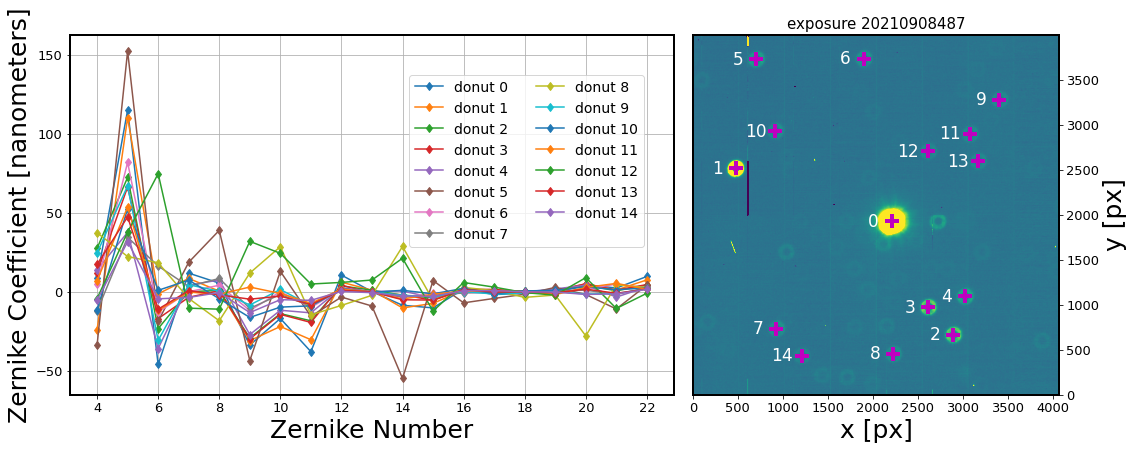

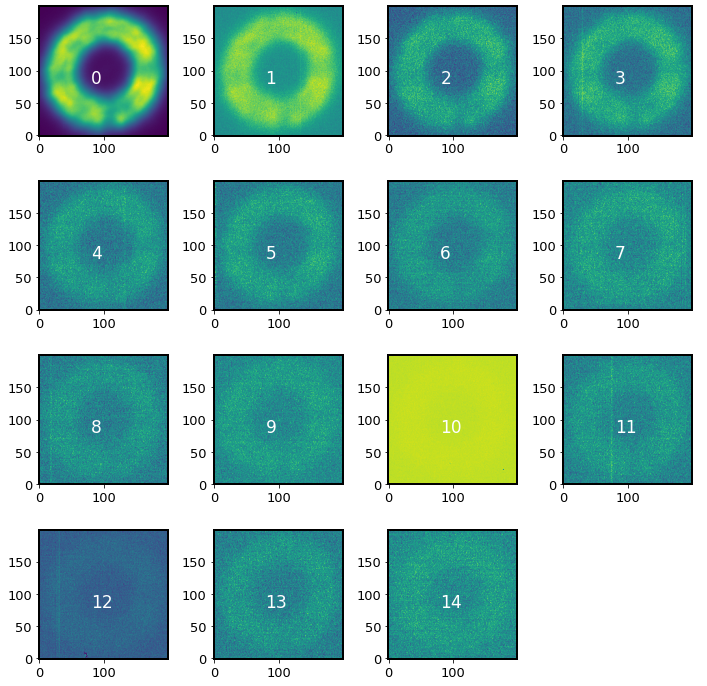

In [37]:
%matplotlib inline
fig = plt.figure(figsize=(14, 5))
zk, don = pt.get_zernikes_donuts_from_pickle('zerDic_2021090800487_extra.npy')
exposure = pt.get_postisr_from_butler('/repo/main/', 'u/scichris/Latiss/postISRex', 2021090800487)
pt.plot_raw_zernikes(zk, fig=fig)
pt.plot_donut_locations(exposure, don, fig=fig)
pt.plot_donut_stamps(don)

## 2) Use donut template fitting to get the source catalog

## 2.1) Load the raw defocal images, do the ISR 
We use the same raw images a above. Show the postISR:

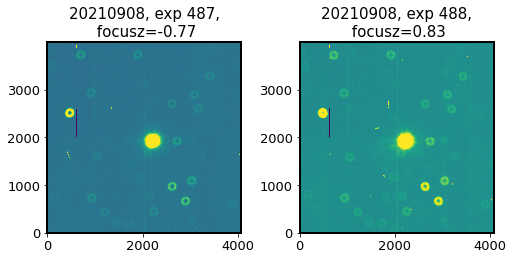

In [38]:
pt.preview_exposures(year_month_day='20210908', 
                     exp_start=487, exp_end=489,
                     dataset_ref_or_type='postISRCCD',
                     collection='u/scichris/Latiss/postISRex'
                    )


## 2.2) Run Zernike estimation using sources from donut template fitting 

In [39]:
%matplotlib inline

def fit_zernikes_donut_template(path_to_repo='/repo/main/', 
                                collection='u/scichris/Latiss/postISRex',
                                instrument="LATISS",
                                detector=0,
                                exp_intra=2021090800487, 
                                exp_extra=2021090800488
                                ):
    
    '''
    Fit for Zernike coefficients extra and intra-focal 
    exposure, by fitting donut template to find 
    source location. 
    
    Parameters
    ----------
    path_to_repo : str (optional)
        Path to butler repository containing the collection
        with postISR exposures
    collection: str (optional)
        Collection name containing the postISR in-focus exposure

        We assume just one collection containing all data.
        For Latiss tests a collection name
        can be "u/scichris/Latiss/test"
    instrument: str (optional)
        Name of instrument eg. LsstCam, LsstComCam, or LATISS
    detector: str or int (optional)
        Name of detector. For LATISS it is 0 , for
        LsstComCam eg. "R22_S10"   
    exp_intra: int (optional)
        Exposure number for intra-focal exposure
    exp_extra: int (optional)
        Exposure number for extra-focal exposure
        
    Returns:
    ---------
    fname: str
        Filename for pickled results.
    '''
    # initialize butler, load 
    # intra, extra exposures, and camera
    butler = dafButler.Butler(path_to_repo, instrument=instrument)
    exposure_intra = butler.get('postISRCCD', 
                                dataId={'instrument':instrument, 
                                        'detector':detector, 
                                        'exposure':exp_intra
                                       },
                                collections=[collection]
                               )


    exposure_extra = butler.get('postISRCCD', 
                                dataId={'instrument':instrument, 
                                        'detector':detector, 
                                        'exposure':exp_extra
                                       },
                                collections=[collection]
                               )

    camera = butler.get("camera",
                        dataId={"instrument": instrument}, 
                        collections=[collection],
                       )
    
    # find donuts from one of the exposures
    exposure = copy(exposure_intra)
    
    # run donut detect task
    donutDetectConfig = GenerateDonutDirectDetectTaskConfig(donutTemplateSize = 200,
                                            instName = 'auxTel',
                                            opticalModel = 'onAxis',
                                            peakThreshold = 0.99,
                                            binaryChoice = 'deblend')
    donutDetectTask = GenerateDonutDirectDetectTask(config=donutDetectConfig)

    donutCatalog = donutDetectTask.run(exposure)
    donutCat = donutCatalog.donutCatalog

    # declare the exposure pair
    exposure_pair = [exposure_intra, exposure_extra]
    
    # run estimate Zernikes task
    estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200, 
                                                             donutTemplateSize=200,
                                                             opticalModel='onAxis')
    estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
    zernikeOutput = estimateZernikeTask.run(exposure_pair, [donutCat], camera)

    # store Zernikes as dict
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{exp_intra}_{exp_extra}_n.npy'
    np.save(fname,zernikes,)
    print(f'Stored the results as {fname} ')
    
    return fname

Run Zernike estimation with sources found via donut template fitting:

In [40]:
fname = fit_zernikes_donut_template()

Stored the results as zerDic_2021090800487_2021090800488_n.npy 


Plot the results:

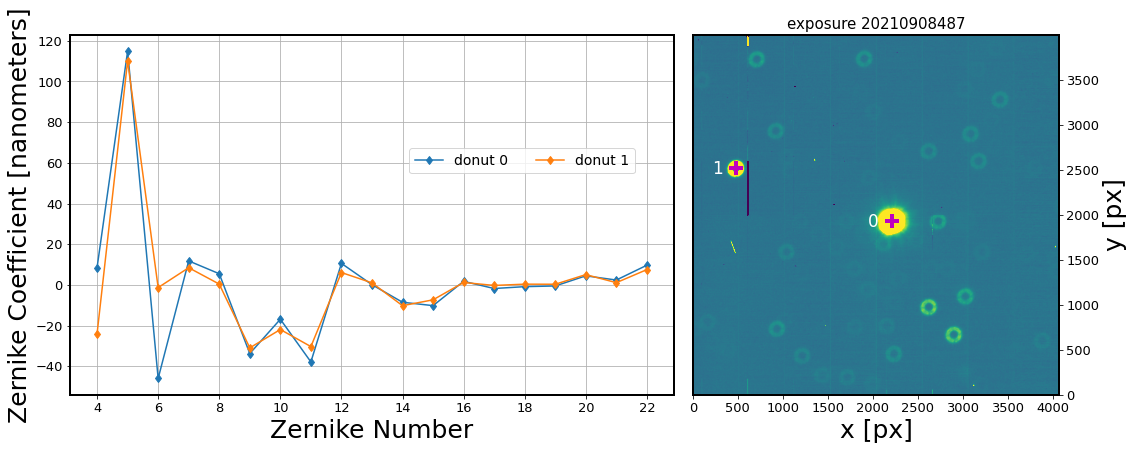

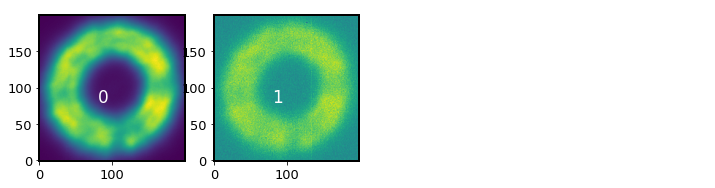

In [42]:
%matplotlib inline
fig = plt.figure(figsize=(14, 5))
zk,don = pt.get_zernikes_donuts_from_pickle(fname)
exposure = pt.get_postisr_from_butler('/repo/main/', 'u/scichris/Latiss/postISRex1', 2021090800487)
pt.plot_raw_zernikes(zk, fig=fig)
pt.plot_donut_locations(exposure, don, fig=fig)
pt.plot_donut_stamps(don)


## 4) Everything as a pipetask

The WCS example above could not be run using the pipeline because the initial WCS guess in `GenerateDonutCatalogWcsTask.py` uses [WCS attached to the exposure](https://github.com/lsst-ts/ts_wep/blob/abd15793e7e0f0484de03661caf4c1783e78a24f/python/lsst/ts/wep/task/GenerateDonutCatalogWcsTask.py#L240), which for auxTel may not be as close as needed for astrometry to converge (rotation < 6 degrees).

Regardless of the accuracy of the WCS attached to the auxTel exposure, the `GenerateDonutDirectDetectTask` can be used to detect donuts via template fitting. 

Once the donut catalog is provided via either of these tasks, the `EstimateZernikesLatissTask` can use that to calculate Zernikes and store everything as a pipetask structure. 

To run everything as pipetask one uses a `yaml` file that contains configuration for all employed tasks. For instance,
to analyze the example data from this notebook we could use a file [very similar to the test](https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testLatissPipeline.yaml) :

    description: auxTel ISR--> donut selection--> Zernike estimation pipeline
    instrument: lsst.obs.lsst.Latiss
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: false
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doNanMasking: false
          doOverscan: true
          doVariance: false
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'
      generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.GenerateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          donutTemplateSize: 200
          removeBlends: True
          instName: 'auxTel'
          opticalModel: 'onAxis'
      estimateZernikesLatissTask:
        class: lsst.ts.wep.task.EstimateZernikesLatissTask.EstimateZernikesLatissTask
        config:
          # And here we specify the configuration settings
          donutTemplateSize: 200
          donutStampSize: 200
          initialCutoutPadding: 40
          instName: 'auxTel'
          opticalModel: 'onAxis'
          
          
Then the entire pipetask can be run with 

    pipetask run  --data-query "exposure IN (2021090800487,2021090800488) AND instrument='LATISS' AND visit_system=0" -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib  --output u/scichris/Latiss/postISRex1 --pipeline /project/scichris/aos/ts_wep/tests/testData/pipelineConfigs/testLatissPipeline.yaml  --register-dataset-types
    

I use a function that employs these data products to plot the combined illustration:

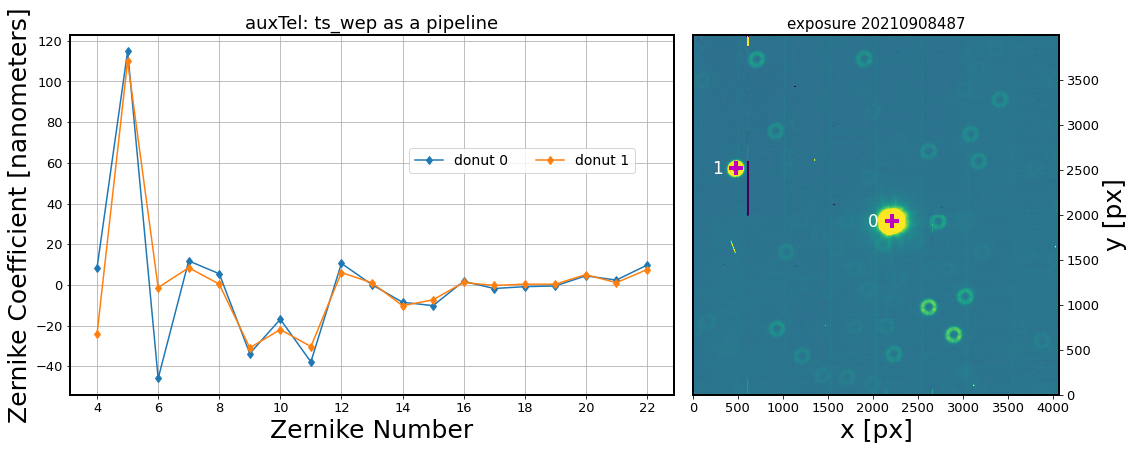

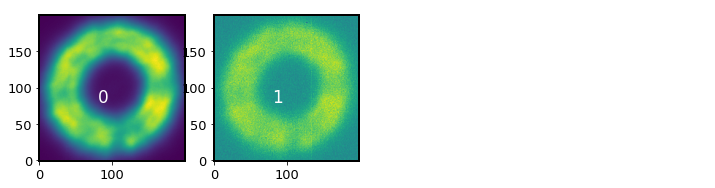

In [43]:
%matplotlib inline
fig = plt.figure(figsize=(14, 5))
zk, don, exposure = pt. get_zernikes_donuts_postisr_from_butler('/repo/main/', 
                                                                collection='u/scichris/Latiss/postISRex2',
                                                                instrument='LATISS',  
                                                                detector=0)
pt.plot_raw_zernikes(zk, fig=fig, title='auxTel: ts_wep as a pipeline')
pt.plot_donut_locations(exposure, don, fig=fig)
pt.plot_donut_stamps(don)

## 5) Summary and conclusion

In summary, there are advantages and disadvantages to using either method.

First, the [method detecting sources](#detection) in the in-focus image using `sourceDetectionTask` relies on provided PSF (since PSF characterization was lacking in the considered exposure), and on set detection thresholds (in particular, `configDetection.thresholdValue` and `configDetection.minPixels` ). Setting these to be too low may result in eg. an error in that all pixels are masked and background cannot be estimated. Furthermore, this requires the in-focus image to be taken at approximately the same location as the defocal exposures, since the same WCS is assumed to be correct. However, with appropriate WCS the defocal sources can be selected from the reference catalog, thus reducing the possibility of image artifacts being detected as sources.

Second, the [method of template fitting](#fitDonuts) to detect defocal donuts using  `DonutDetector` `detectDonuts` depends on the settings passed therein, consisting of `blendRadius` in pixels, and `peakThreshold`. We also made a choice to remove the `blended` donuts to clean up the catalog. This method works well when required  to detect a few brightest donuts in the image. However, if it is  important to use as many donuts as possible, then it may be easier to select them using a magnitude cut  on the reference star catalog used in the first method. 
